In [1]:
from collections import deque
from matplotlib import pyplot as plt
from random import randint
from time import time
import torch

device = torch.device('cpu')

In [2]:
class SnakeEnv:
	C_EMPTY, C_FOOD, C_HEAD, C_BODY_UP, C_BODY_RIGHT, C_BODY_DOWN, C_BODY_LEFT = 0, 1, 2, 3, 4, 5, 6
	D_UP, D_RIGHT, D_DOWN, D_LEFT = 0, 1, 2, 3

	def __init__(self, size=5):
		self.size = size
		self.reset()

	def reset(self):
		self.board = torch.zeros((self.size, self.size), dtype=torch.int, device=device)
		self.body = deque([(randint(0, self.size - 1), randint(0, self.size - 1))])
		self.board[*self.body[0]] = SnakeEnv.C_HEAD
		self._place_food()
		return self.board

	def step(self, action):
		if action == SnakeEnv.D_UP: new_head = (self.body[0][0] - 1, self.body[0][1])
		elif action == SnakeEnv.D_RIGHT: new_head = (self.body[0][0], self.body[0][1] + 1)
		elif action == SnakeEnv.D_DOWN: new_head = (self.body[0][0] + 1, self.body[0][1])
		elif action == SnakeEnv.D_LEFT: new_head = (self.body[0][0], self.body[0][1] - 1)
		if not (0 <= new_head[0] < self.size and 0 <= new_head[1] < self.size) or self.board[*new_head] > SnakeEnv.C_HEAD and new_head != self.body[-1]:
			reward, done = 0, True
		else:
			self.body.appendleft(new_head)
			if new_head == self.food:
				if len(self.body) == self.size * self.size:
					reward, done = 1, True
				else:
					reward, done = 1, False
					self._place_food()
			else:
				self.board[*self.body[-1]] = SnakeEnv.C_EMPTY
				self.body.pop()
				reward, done = 0, False
			self.board[*new_head] = SnakeEnv.C_HEAD
			if len(self.body) > 1:
				self.board[*self.body[1]] = [SnakeEnv.C_BODY_UP, SnakeEnv.C_BODY_RIGHT, SnakeEnv.C_BODY_DOWN, SnakeEnv.C_BODY_LEFT][action]
		return self.board, reward, done

	def _place_food(self):
		while True:
			food = (randint(0, self.size - 1), randint(0, self.size - 1))
			if self.board[*food] == SnakeEnv.C_EMPTY: break
		self.food = food
		self.board[*self.food] = SnakeEnv.C_FOOD
	
	def render(self):
		print('\n'.join(''.join('·○●▲▶▼◀'[cell] for cell in row) for row in self.board))

env = SnakeEnv()
env.render()

···●·
·····
·····
·····
····○


In [3]:
class Agent(torch.nn.Module):
	NUM_CLASSES = 7
	def __init__(self, board_size=5, hidden_size=27, depth=5):
		super().__init__()
		self.register_buffer('diagonal', torch.eye(Agent.NUM_CLASSES, device=device))
		self.input = torch.nn.Linear(board_size**2 * Agent.NUM_CLASSES, hidden_size)
		self.hidden = torch.nn.ModuleList([
			torch.nn.Sequential(
				torch.nn.Linear(hidden_size, hidden_size),
				torch.nn.GELU(),
				torch.nn.LayerNorm(hidden_size)
			) for _ in range(depth)
		])
		self.actor = torch.nn.Linear(hidden_size, 4, bias=False)
		self.critic = torch.nn.Linear(hidden_size, 1)

	def forward(self, x):
		x = self.diagonal[x.flatten(-2)].flatten(-2)
		x = self.input(x).relu()
		for layer in self.hidden:
			x = x + layer(x)
		return self.actor(x).softmax(dim=-1), self.critic(x).squeeze(-1)

agent = Agent().to(device)
print(f'Agent has {sum(p.numel() for p in agent.parameters()):,} parameters')

Agent has 8,938 parameters


In [4]:
def play_episode(eps=0, max_steps_without_reward=100):
	states = [env.reset().clone()]
	values, rewards, logits, entropies = [], [], [], []
	steps_without_reward = 0
	while True:
		action_probs, value = agent(states[-1])
		if torch.rand(()) < eps:
			action = torch.randint(0, 4, ())
		else:
			action = torch.multinomial(action_probs, 1).item()
		state, reward, done = env.step(action)
		states.append(state.clone())
		values.append(value.unsqueeze(0))
		rewards.append(reward)
		logits.append(torch.log(action_probs[action] + 1e-8))
		entropies.append(-(action_probs * torch.log(action_probs + 1e-8)).sum())
		if reward == 0:
			steps_without_reward += 1
			if steps_without_reward >= max_steps_without_reward:
				done = True
		else:
			steps_without_reward = 0
		if done: break
	return states, values, rewards, logits, entropies

In [5]:
def avg(lst):
	return sum(lst) / len(lst) if lst else 0

def train(lr=2e-4, episodes=100_000, gamma=.9, max_eps=.3, critic_coeff=.25, entropy_coeff=.01):
	print('PROGRESS | REMAINING | ACTOR LOSS | CRITIC LOSS | ENTROPY LOSS | AVG REWARD')
	optimizer = torch.optim.AdamW(agent.parameters(), lr=lr)
	stats = {'rewards': [], 'actor_losses': [], 'critic_losses': [], 'entropy_losses': []}
	start = time()
	for e in range(episodes):
		progress = (e + 1) / episodes
		_, values, rewards, logits, entropies = play_episode(eps=max_eps * (1 - progress))
		stats['rewards'].append(sum(rewards))
		# calculate discounted rewards	
		for i in range(len(rewards) - 2, -1, -1):
			rewards[i] += rewards[i + 1] * gamma
		# calculate advantage
		values = torch.cat(values)
		logits = torch.stack(logits)
		advantage = torch.tensor(rewards, device=device) - values
		# compute actor and critic losses
		actor_loss = (-logits * advantage.detach()).mean()
		critic_loss = advantage.pow(2).mean()
		entropy_loss = torch.stack(entropies).mean()
		loss = actor_loss + critic_loss * critic_coeff - entropy_loss * entropy_coeff
		stats['actor_losses'].append(actor_loss.item())
		stats['critic_losses'].append(critic_loss.item())
		stats['entropy_losses'].append(entropy_loss.item())
		# optimize
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		# show progress
		if e % (episodes // 10) == 0 and e > 0 or e == 50 or e == episodes - 1:
			remaining = (time() - start) * (1 - progress) / progress
			print(f'{100 * progress:7.2f}% |     {remaining // 60:02.0f}:{remaining % 60:02.0f} | {avg(stats["actor_losses"][-1000:]):10.4f} | {avg(stats["critic_losses"][-1000:]):11.4f} | {avg(stats["entropy_losses"][-1000:]):12.4f} | {avg(stats["rewards"][-1000:]):10.4f}')
	return stats

print('Training with exponentially decaying epsilon:')
stats = train()
print('Fine-tuning with no epsilon and lower learning rate:')
stats2 = train(lr=2e-5, episodes=50_000, max_eps=0)
for key in stats: stats[key].extend(stats2[key])

Training with exponentially decaying epsilon:
PROGRESS | REMAINING | ACTOR LOSS | CRITIC LOSS | ENTROPY LOSS | AVG REWARD
   0.05% |     05:47 |     0.0692 |      0.1894 |       1.0917 |     0.2157


KeyboardInterrupt: 

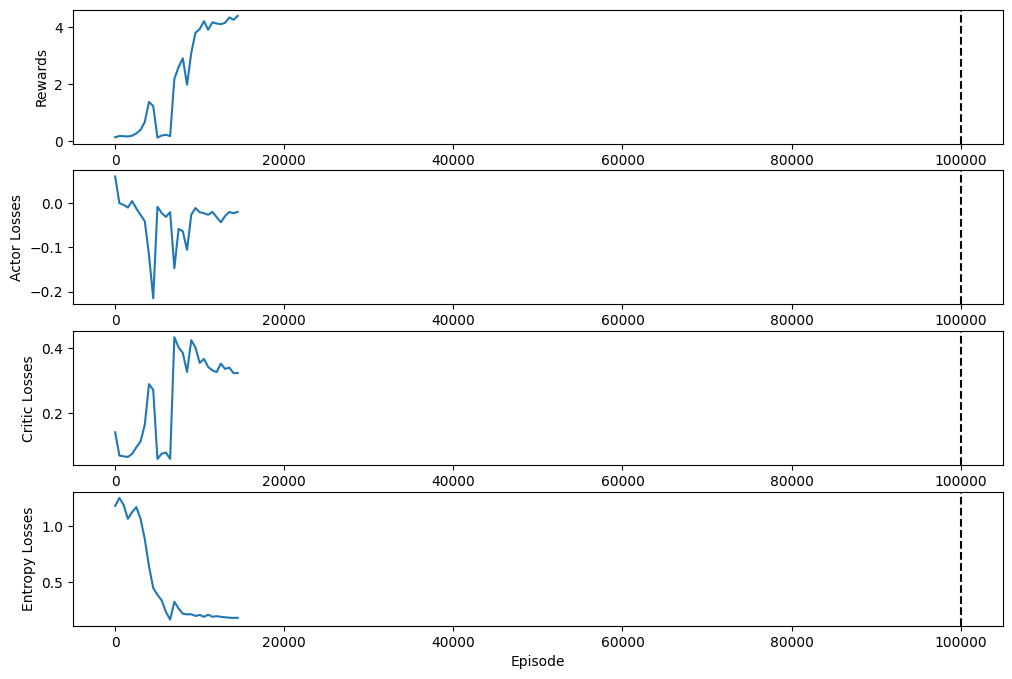

In [ ]:
plt.figure(figsize=(12, 8))
for i, (key, losses) in enumerate(stats.items(), 1):
	plt.subplot(len(stats), 1, i)
	plt.xlabel('Episode')
	plt.ylabel(key.replace('_', ' ').title())
	plt.plot(range(0, len(stats[key]), 500), torch.tensor(stats[key], dtype=torch.float32, device='cpu').view(-1, 500).mean(1))
	plt.axvline(x=100_000, color='k', linestyle='--')

In [ ]:
from cv2 import VideoWriter, VideoWriter_fourcc  # pip install opencv-python opencv-contrib-python

best_reward = 0
best_states = None
for _ in range(1000):
	states, _, rewards, *_ = play_episode()
	reward = sum(rewards)
	if reward > best_reward:
		best_reward = reward
		best_states = states
states = torch.stack(best_states)

palette = torch.tensor([[0, 0, 0], [0, 255, 0], [255, 255, 0], [255, 0, 0], [255, 0, 0], [255, 0, 0], [255, 0, 0]], dtype=torch.uint8)
video = palette[states]
scaling_factor = video.shape[-2] * 40
video = torch.nn.functional.interpolate(
	video.permute(0, 3, 1, 2).float(),
	size=(scaling_factor, scaling_factor),
	mode='nearest'
).byte().permute(0, 2, 3, 1).numpy()
fourcc = VideoWriter_fourcc(*'mp4v')
out = VideoWriter('snake_animation.mp4', fourcc, 10, (scaling_factor, scaling_factor))
for frame in video: out.write(frame)
out.release()

torch.Size([83, 5, 5])
